In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil import relativedelta
 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import joblib

In [2]:
df = pd.read_csv(r"Dataset/Churn_Modelling_post_EDA.csv")
print(df.shape)
print(df.columns)
df.head()

(10000, 19)
Index(['CustomerId', 'CreditScore', 'Region', 'Gender', 'Age', 'ACCT_OPN_DATE',
       'M_Minus_one_Bal', 'Total_FD_Amt', 'HasCrCard', 'Last_Login_Date',
       'EstimatedSalary', 'Acct_Cls_Flag', 'Current_balance',
       'M_Minus_two_Bal', 'Acct_vintage', 'Login_vintage',
       'CreditScore_buckets', 'Age_buckets', 'Churn'],
      dtype='object')


,CustomerId,CreditScore,Region,Gender,Age,ACCT_OPN_DATE,M_Minus_one_Bal,Total_FD_Amt,HasCrCard,Last_Login_Date,EstimatedSalary,Acct_Cls_Flag,Current_balance,M_Minus_two_Bal,Acct_vintage,Login_vintage,CreditScore_buckets,Age_buckets,Churn
0,15586039,471,Western,Female,36,2023-03-08,304683,490000,0,2023-06-08,96366.70,0,415351,292972,166,74,a.<580,b.30-40,0
1,15723250,519,South,Male,42,2022-12-08,37261,490000,1,2023-06-08,101485.72,0,396451,123094,256,74,a.<580,c.40-60,0
2,15581840,626,South,Male,33,2022-12-08,346591,500000,1,2023-08-08,138504.28,0,22758,55854,256,13,b.580-660,b.30-40,1
3,15662238,822,South,Male,37,2023-05-08,393118,500000,1,2023-08-08,182624.93,0,340244,278305,105,13,e.800+,b.30-40,0
4,15795151,705,South,Female,38,2023-05-08,107895,480000,0,2023-05-08,21177.10,0,317835,131458,105,105,c.660-720,b.30-40,0


In [3]:
df = pd.get_dummies(df,columns = ['Region','Gender','CreditScore_buckets','Age_buckets'],drop_first = True)

In [4]:
cols_to_remove_in_training = ['CustomerId','CreditScore','Age','ACCT_OPN_DATE','Last_Login_Date',
                  'Current_balance','M_Minus_two_Bal','M_Minus_one_Bal']

target = 'Churn'
cols_to_remove_in_training.append(target)


In [5]:
training_cols = [i for i in list(df.columns) if i not in cols_to_remove_in_training]

X = df[training_cols]
y = df[[target]]

# Scaling all the variables to a range of 0 to 1
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

joblib.dump(scaler, "min_max_scaler.pkl")

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=41)

In [6]:
X_train.head(2)

,Total_FD_Amt,HasCrCard,EstimatedSalary,Acct_Cls_Flag,Acct_vintage,Login_vintage,Region_South,Region_Western,Gender_Male,CreditScore_buckets_b.580-660,CreditScore_buckets_c.660-720,CreditScore_buckets_d.720-800,CreditScore_buckets_e.800+,Age_buckets_b.30-40,Age_buckets_c.40-60,Age_buckets_d.60+
9818,0.96,1.0,0.778734,0.0,0.697368,0.336957,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3134,0.08,0.0,0.468822,0.0,0.697368,0.336957,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
y_train[target].value_counts()*100/len(y_train)

0    78.9
1    21.1
Name: Churn, dtype: float64

In [8]:
y_test[target].value_counts()*100/len(y_test)

0    79.266667
1    20.733333
Name: Churn, dtype: float64

Model training

In [9]:
model = LogisticRegression()
result = model.fit(X_train, y_train)
joblib.dump(model, 'LogisticRegression.pkl') 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['LogisticRegression.pkl']

In [10]:
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (accuracy_score(y_test, prediction_test))

0.7926666666666666


AxesSubplot(0.125,0.125;0.775x0.755)


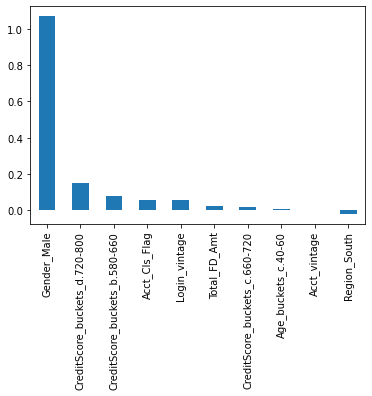

In [11]:
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


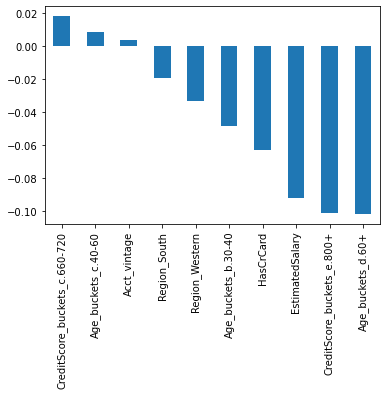

In [12]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (accuracy_score(y_test, prediction_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.792


<AxesSubplot:>

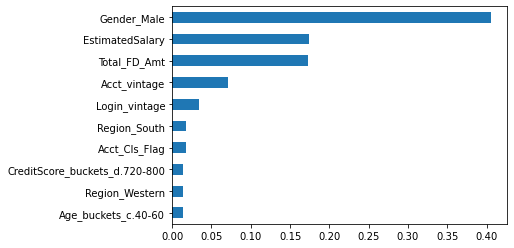

In [14]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

In [15]:

model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.7675

<AxesSubplot:>

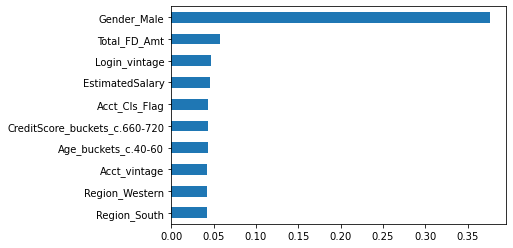

In [16]:
importances = model.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

Since we want to understand the parameters based on which decisions are made so that those can be improved and acted upon we should be vary of blackbox models, and as already seen in our example Logistic is performaaing on par with random forest and XGBoost. If it was performaing very suboptimal then that would have been a different case. But Now lest just take Logistic Regression. This will be very useful information for product and marketing teams. For example, if we know that credit score plays a part in churn, we can use this to create more effective campaigns and pricing strategy for low value clients.